In [15]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from scipy.integrate import simpson

In [16]:
# Constants

D = 100
z_H = 100
C_star = 4.5
f = 1e-4
kappa = 0.4
z_0 = 0.0001
s_x = 10
s_y = 10
U_0 = 10.0
C_T = 0.8
RL = 100 * D

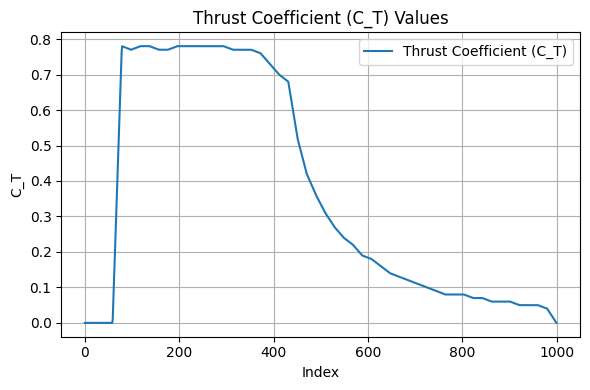

In [17]:
# Park Setup
theta_deg = 0
theta = np.radians(theta_deg)
resolution = 10

# Define the unit vectors in original directions
dx = np.array([s_x, 0])
dy = np.array([0, s_y])

# Rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Rotate the unit vectors
dx_rot = R @ dx
dy_rot = R @ dy

# Projected spacings along global x and y
s_x_global = np.abs(dx_rot)
s_y_global = np.abs(dy_rot)

s_x = s_x_global[0] + s_x_global[1]
s_y = s_y_global[0] + s_y_global[1]

#print(f"s_x: {s_x}, s_y: {s_y}")

# Initialize thrust curve
u = np.arange(0, 26, .5)  # [m/s]
C_T_var = np.array([0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0])

# Interpolate thrust curve
u_interp = np.linspace(u.min(), u.max(), 1000)
C_T_interp = interp1d(u, C_T_var, kind='linear')(u_interp)

plt.figure(figsize=(6, 4))
plt.plot(C_T_interp, label='Thrust Coefficient (C_T)')
plt.xlabel('Index')
plt.ylabel('C_T')
plt.title('Thrust Coefficient (C_T) Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

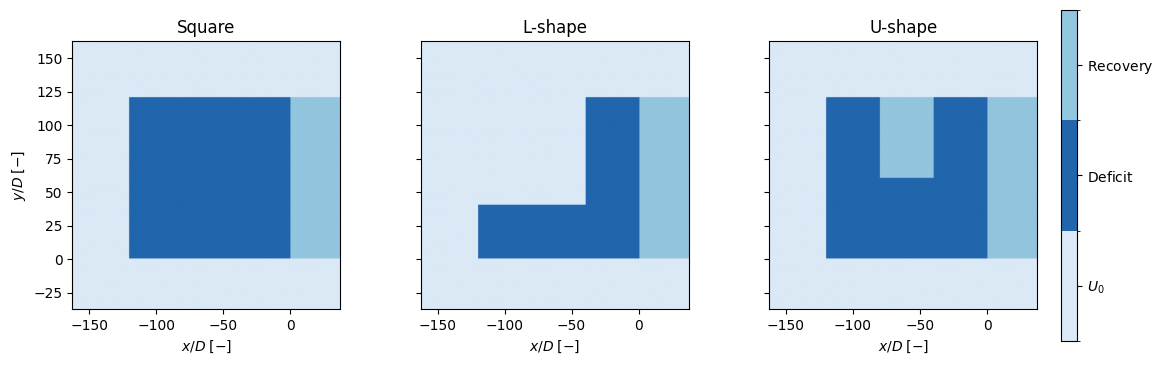

Max y with farm for Rectangle (in D): 120.0
Max y with farm for L-shape (in D): 120.0
Max y with farm for U-shape (in D): 120.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.path import Path

# Wind farm mask generator
def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None, rotation_degrees=0):
    points = np.array(corner_points)

    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
        points = np.dot(translated_points, R.T) + centroid

    # Align bottom-right corner to (0,0)
    min_y = points[:, 1].min()
    points[:, 1] -= min_y
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Set canvas limits in meters (nonrotated)
    min_x = -162.5 * D
    max_x = 37.5 * D
    min_y = -37.5 * D
    max_y = 162.5 * D

    # Set canvas limits in meters (rotated)
    #min_x = -200 * D
    #max_x = 37.5 * D
    #min_y = -37.5 * D
    #max_y = 200 * D

    x_range = np.arange(min_x, max_x + resolution, resolution)
    y_range = np.arange(min_y, max_y + resolution, resolution)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range, points

# Zone classification
def generate_zone_map(mask_2d, x_range, recovery_x_end):
    zone_map = np.full(mask_2d.shape, 0, dtype=int)

    for row_idx, row in enumerate(mask_2d):
        true_indices = np.where(row == 1)[0]
        if true_indices.size == 0:
            continue

        diffs = np.diff(true_indices)
        split_points = np.where(diffs > 1)[0]
        segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
        segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

        for start, end in zip(segment_starts, segment_ends):
            if end - start + 1 > 1:
                zone_map[row_idx, start:end + 1] = 1  # Deficit

        for i in range(len(segment_ends) - 1):
            gap_start = segment_ends[i] + 1
            gap_end = segment_starts[i + 1] - 1
            if gap_start <= gap_end:
                zone_map[row_idx, gap_start:gap_end + 1] = 2  # Recovery

        last_farm_x = x_range[segment_ends[-1]]
        recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
        zone_map[row_idx, recovery_indices] = 2

        last_valid_idx = segment_ends[-1]
        zone_map[row_idx, last_valid_idx + 1:] = np.where(
            zone_map[row_idx, last_valid_idx + 1:] == 1,
            2,
            zone_map[row_idx, last_valid_idx + 1:]
        )

    return zone_map

# --- Define parks ---
corner_points1 = [(0, 0), (12000, 0), (12000, 12000), (0, 12000)]  # Rectangle
corner_points2 = [(0, 0), (12000, 0), (12000, 4000), (4000, 4000), (4000, 12000), (0, 12000)]  # L-shape
corner_points3 = [(0, 0), (12000, 0), (12000, 12000), (8000, 12000), (8000, 6000), (4000, 6000), (4000, 12000), (0, 12000)]  # U-shape

# Constants
D = 100  # Rotor diameter
resolution = 10
PL = 1  # Example value

theta_deg = 360 #- 90
# Generate masks and zones
mask1, x_range1, y_range1, points1 = create_wind_farm_mask(corner_points1, resolution, 'x', 160 * D, theta_deg)
zone_map1 = generate_zone_map(mask1, x_range1, 160 * D)

theta_deg = 360 #- 110
mask2, x_range2, y_range2, points2 = create_wind_farm_mask(corner_points2, resolution, 'x', 160 * D, theta_deg)
zone_map2 = generate_zone_map(mask2, x_range2, 160 * D)

theta_deg = 360 #- 45
mask3, x_range3, y_range3, points3 = create_wind_farm_mask(corner_points3, resolution, 'x', 160 * D, theta_deg)
zone_map3 = generate_zone_map(mask3, x_range3, 160 * D)

# --- Plot 3 maps side by side ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.05)  # Increase the space between plots

cmap = mcolors.ListedColormap(['#dbe9f6', '#2166ac', '#92c5de'])  # Blue scale
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

zone_maps = [zone_map1, zone_map2, zone_map3]
x_ranges = [x_range1, x_range2, x_range3]
y_ranges = [y_range1, y_range2, y_range3]
titles = ["Square", "L-shape", "U-shape"]

for ax, zm, x_r, y_r, title in zip(axes, zone_maps, x_ranges, y_ranges, titles):
    extent = [x_r[0]/D, x_r[-1]/D, y_r[0]/D, y_r[-1]/D]
    im = ax.imshow(zm, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='equal')
    ax.set_title(title)
    ax.set_xlabel(r"$ x/D \; [-] $")
    if ax == axes[0]:
        ax.set_ylabel(r"$y/D \; [-]$")
    else:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.grid(False)

# Increase space between plots
fig.subplots_adjust(wspace=0.3)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.86, pad=0.02)
cbar.set_ticks([0.5, 1.5, 2.5])
cbar.set_ticklabels([r"$U_0$", r"$\mathrm{Deficit}$", r"$\mathrm{Recovery}$"])
cbar.set_label("")

plt.show()

def get_max_y_in_farm(mask_2d, y_range):
    row_indices = np.where(mask_2d.any(axis=1))[0]
    if len(row_indices) == 0:
        return None
    max_row = row_indices[-1]
    return y_range[max_row]

# Or in rotor diameters:
print(f"Max y with farm for Rectangle (in D): {get_max_y_in_farm(mask1, y_range1) / D}")
print(f"Max y with farm for L-shape (in D): {get_max_y_in_farm(mask2, y_range2) / D}")
print(f"Max y with farm for U-shape (in D): {get_max_y_in_farm(mask3, y_range3) / D}")

# TDM

In [19]:
def calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c):

    c_t = (np.pi * C_T * D**2) / (8 * s_d * s_c)

    nu_star = 28 * np.sqrt(c_t)
    
    beta =  nu_star / (1 + nu_star)
    
    z_0WF = z_H * (1 + D / (2 * z_H))**beta * np.exp(-kappa * (c_t + (kappa / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5)

    x = np.linspace(x_1, x_3-1, int(x_3-x_1))

    h_1 = np.full_like(x, np.nan, dtype=float)
    h_2 = np.full_like(x, np.nan, dtype=float)

    alpha_def = 0.8

    alpha_rec = 0.8

    h_1[x >= x_1] = (z_H/z_0WF + ((x[x >= x_1] - x_1) / z_0WF)**alpha_def) * z_0WF
    h_2[x >= x_2] =   (0/z_0WF + ((x[x >= x_2] - x_2) / z_0WF)**alpha_rec) * z_0WF

    U = np.full_like(x, np.nan, dtype=float)
    U[0] = U_0

    idx1 = (h_1 >= z_H)
    U[idx1] = U_0 * (np.log(h_1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h_1[idx1] / z_0WF) * np.log(z_H / z_0))

    idx2 = (x >= x_2) & (h_2 >= z_H)
    U[idx2] = U_0 * (np.log(h_1[idx2] / z_0) * np.log(h_2[idx2] / z_0WF)) / (np.log(h_1[idx2] / z_0WF) * np.log(h_2[idx2] / z_0))

    for i in range(1, len(U)):
        if U[i] >= U_0 * 0.9999:
            U[i] = U_0 * 0.9999
        elif U[i] < 0:
            U[i] = 0

    return x, U, h_1

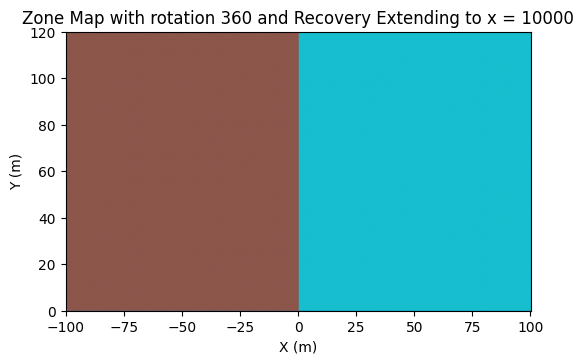

y_resolution: 100


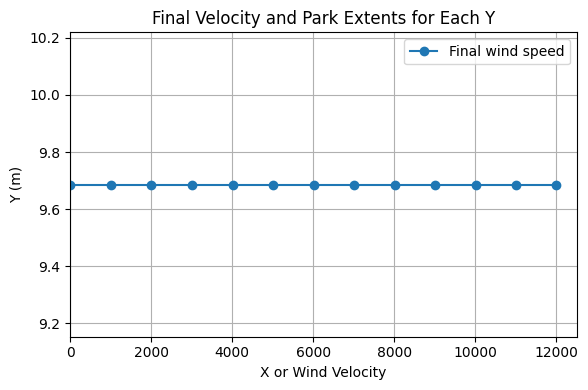

In [20]:
# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 0
    y_padding = 0
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding

    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range, points

# --- Define park shape ---
corner_points = [(0, 0), (10000, 0), (10000, 12000), (0, 12000)]
rotation_degrees = 360
mirror_axis = 'x'
recovery_x_end = RL

# Generate mask
mask_2d, x_range, y_range, points1 = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end
)

ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2
zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]
    if true_indices.size == 0:
        zone_map[row_idx] = ZONE_UH0
        continue
    diffs = np.diff(true_indices)
    split_points = np.where(diffs > 1)[0]
    segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
    segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]
    for start, end in zip(segment_starts, segment_ends):
        zone_map[row_idx, start:end + 1] = ZONE_DEFICIT
    for i in range(len(segment_ends) - 1):
        gap_start = segment_ends[i] + 1
        gap_end = segment_starts[i + 1] - 1
        if gap_start <= gap_end:
            zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY
    last_farm_x = x_range[segment_ends[-1]]
    recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
    zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()
for i in range(zone_map.shape[0]):
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

plt.figure(figsize=(6, 6))
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
im = plt.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
plt.title(f"Zone Map with rotation {theta_deg} and Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('scaled')
plt.show()

# Arbitrary TDM

y_resolution = int((s_y * D)/resolution)
print(f"y_resolution: {y_resolution}")

# --- Identify turbine y-indices including park edges ---
park_mask_sums = mask_2d.sum(axis=1)
turbine_rows = np.where(park_mask_sums > 0)[0]
if len(turbine_rows) == 0:
    raise ValueError("No turbine rows detected in the park mask.")

min_idx, max_idx = turbine_rows[0], turbine_rows[-1]
y_indices = list(range(min_idx, max_idx + 1, y_resolution))
if min_idx not in y_indices:
    y_indices.insert(0, min_idx)
if max_idx not in y_indices:
    y_indices.append(max_idx)


results = []
for y_idx in y_indices:
    row = zone_map[y_idx]
    y_val = y_range[y_idx]
    current_zone_type = row[0]
    start_idx = 0
    for idx in range(1, len(row) + 1):
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):
                start_idx = idx
                current_zone_type = row[idx]

final_velocity_data = []
current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]
    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        x, uw, h_1 = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)

        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)

        i += 2
    else:
        i += 1

final_velocity_profile1 = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

plt.figure(figsize=(6, 4))
plt.plot(final_velocity_profile1[:, 0], final_velocity_profile1[:, 1], marker='o', label='Final wind speed')
plt.xlabel('X or Wind Velocity')
plt.ylabel('Y (m)')
plt.xlim(0, 125 * D)
plt.title('Final Velocity and Park Extents for Each Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


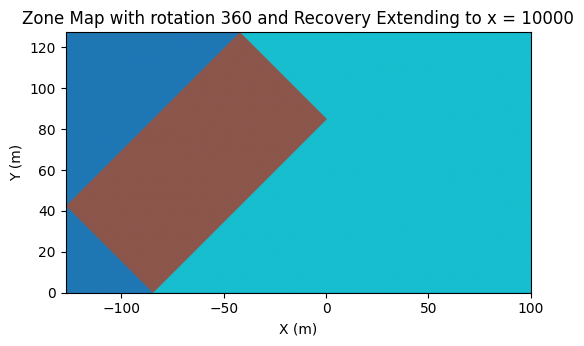

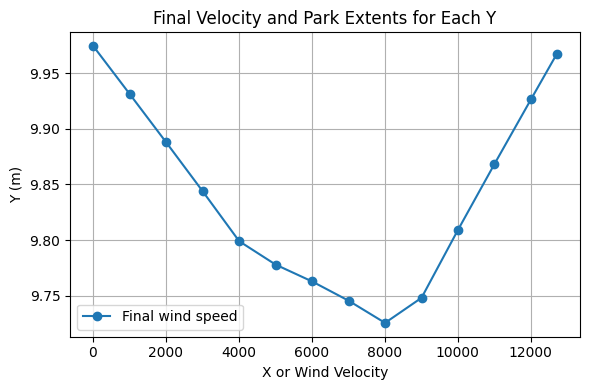

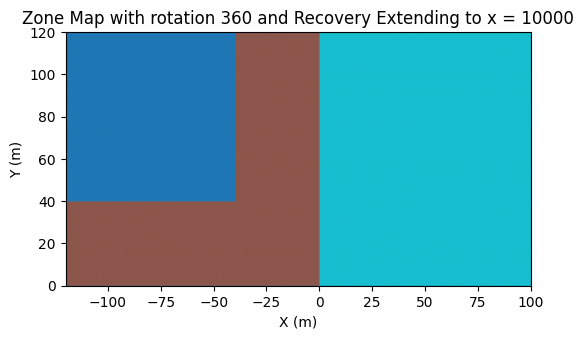

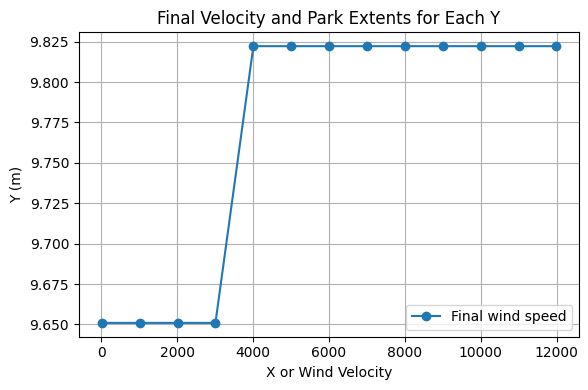

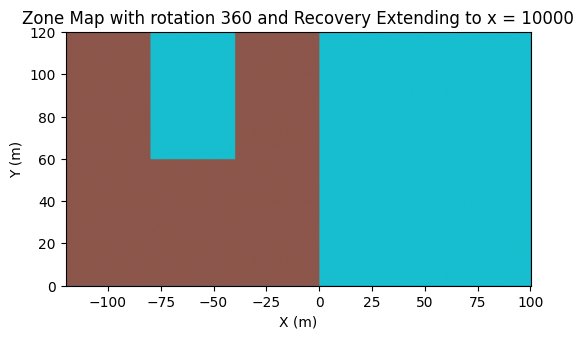

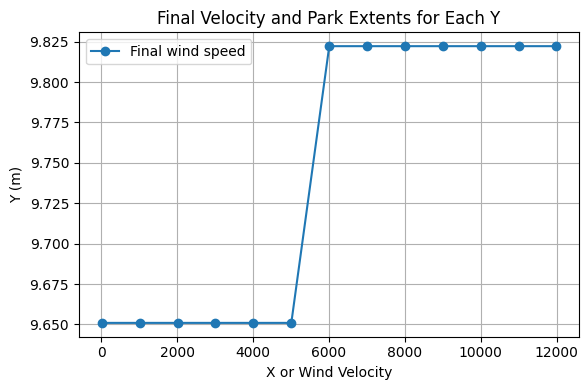

In [30]:
# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 0  # meters
    y_padding = 0  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding

    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range, points


# --- Define park shape ---
corner_points = [(0, 0), (6000, 0), (6000, 12000), (0, 12000)]  # Rectangle
rotation_degrees = 360 - 45
mirror_axis = 'x'
recovery_x_end = RL # set recovery limit

"""
corner_points = [(0, 0), (12000, 0), (12000, 4000), (4000, 4000), (4000, 12000), (0, 12000)]  # L-shape
rotation_degrees = 360 - 110

corner_points = [(0, 0), (12000, 0), (12000, 12000), (8000, 12000), (8000, 6000), (4000, 6000), (4000, 12000), (0, 12000)]  # U-shape
rotation_degrees = 360 - 45
"""

# Generate mask
mask_2d, x_range, y_range, points1 = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size == 0:
        zone_map[row_idx] = ZONE_UH0
        continue

    diffs = np.diff(true_indices)
    split_points = np.where(diffs > 1)[0]
    segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
    segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

    for start, end in zip(segment_starts, segment_ends):
        zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

    for i in range(len(segment_ends) - 1):
        gap_start = segment_ends[i] + 1
        gap_end = segment_starts[i + 1] - 1
        if gap_start <= gap_end:
            zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

    last_farm_x = x_range[segment_ends[-1]]
    recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
    zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()

for i in range(zone_map.shape[0]):
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

plt.figure(figsize=(6, 6))
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
plt.title(f"Zone Map with rotation {theta_deg} and Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('scaled')
plt.show()

# Arbitrary TDM 

y_resolution = int((s_y * D)/resolution)

# --- Identify turbine y-indices including park edges ---
park_mask_sums = mask_2d.sum(axis=1)
turbine_rows = np.where(park_mask_sums > 0)[0]
if len(turbine_rows) == 0:
    raise ValueError("No turbine rows detected in the park mask.")

min_idx, max_idx = turbine_rows[0], turbine_rows[-1]
y_indices = list(range(min_idx, max_idx + 1, y_resolution))
if min_idx not in y_indices:
    y_indices.insert(0, min_idx)
if max_idx not in y_indices:
    y_indices.append(max_idx)

results = []

for y_idx in y_indices:
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):
                start_idx = idx
                current_zone_type = row[idx]

final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        x, uw, h_1 = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue

        deficit_end_uw = uw[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'], deficit_end_uw, h_1[int(x_2)])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)

        i += 2
    else:
        i += 1

final_velocity_profile1 = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

plt.figure(figsize=(6, 4))
plt.plot(final_velocity_profile1[:, 0], final_velocity_profile1[:, 1], marker='o', label='Final wind speed')
plt.xlabel('X or Wind Velocity')
plt.ylabel('Y (m)')
plt.title('Final Velocity and Park Extents for Each Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
















# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 0  # meters
    y_padding = 0  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding

    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range, points


# --- Define park shape ---
corner_points = [(0, 0), (12000, 0), (12000, 4000), (4000, 4000), (4000, 12000), (0, 12000)]  # L-shape
rotation_degrees = 360
mirror_axis = 'x'
recovery_x_end = RL # set recovery limit

# Generate mask
mask_2d, x_range, y_range, points2 = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size == 0:
        zone_map[row_idx] = ZONE_UH0
        continue

    diffs = np.diff(true_indices)
    split_points = np.where(diffs > 1)[0]
    segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
    segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

    for start, end in zip(segment_starts, segment_ends):
        zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

    for i in range(len(segment_ends) - 1):
        gap_start = segment_ends[i] + 1
        gap_end = segment_starts[i + 1] - 1
        if gap_start <= gap_end:
            zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

    last_farm_x = x_range[segment_ends[-1]]
    recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
    zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()

for i in range(zone_map.shape[0]):
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

plt.figure(figsize=(6, 6))
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
plt.title(f"Zone Map with rotation {theta_deg} and Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('scaled')
plt.show()

# Arbitrary TDM 

y_resolution = int((s_y * D)/resolution)

# --- Identify turbine y-indices including park edges ---
park_mask_sums = mask_2d.sum(axis=1)
turbine_rows = np.where(park_mask_sums > 0)[0]
if len(turbine_rows) == 0:
    raise ValueError("No turbine rows detected in the park mask.")

min_idx, max_idx = turbine_rows[0], turbine_rows[-1]
y_indices = list(range(min_idx, max_idx + 1, y_resolution))
if min_idx not in y_indices:
    y_indices.insert(0, min_idx)
if max_idx not in y_indices:
    y_indices.append(max_idx)

results = []

for y_idx in y_indices:
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):
                start_idx = idx
                current_zone_type = row[idx]

final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        x, uw, h_1 = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue

        deficit_end_uw = uw[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'], deficit_end_uw, h_1[int(x_2)])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)

        i += 2
    else:
        i += 1

final_velocity_profile2 = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

plt.figure(figsize=(6, 4))
plt.plot(final_velocity_profile2[:, 0], final_velocity_profile2[:, 1], marker='o', label='Final wind speed')
plt.xlabel('X or Wind Velocity')
plt.ylabel('Y (m)')
plt.title('Final Velocity and Park Extents for Each Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()













# Park Masking

def create_wind_farm_mask(corner_points, resolution=10, mirror_axis=0, recovery_x_end=None):
    points = np.array(corner_points)

    # Apply mirroring
    if mirror_axis:
        if 'x' in mirror_axis:
            points[:, 0] = -points[:, 0]
        if 'y' in mirror_axis:
            points[:, 1] = -points[:, 1]

    # Apply rotation
    if rotation_degrees != 0:
        centroid = points.mean(axis=0)
        translated_points = points - centroid
        theta = np.radians(rotation_degrees)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        points = np.dot(translated_points, rotation_matrix.T) + centroid

    # Align rightmost (downstream) edge to x = 0
    max_x = points[:, 0].max()
    points[:, 0] -= max_x

    # Align bottom of park to y = 0
    min_y = points[:, 1].min()
    points[:, 1] -= min_y

    # Determine bounds
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)

    # Expand x and y bounds slightly
    x_padding = 0  # meters
    y_padding = 0  # meters
    min_x -= x_padding
    min_y -= y_padding
    if recovery_x_end is not None:
        max_x = max(max_x, recovery_x_end)
    max_y += y_padding

    # Create y_range
    y_highres_bottom = np.array([])
    y_normal = np.arange(min_y, max_y + resolution, resolution)
    y_range = np.concatenate([y_highres_bottom, y_normal])

    # Create x_range with extended domain
    x_range = np.arange(min_x, max_x + resolution, resolution)

    # Build grid
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create polygon path and mask
    polygon_path = Path(points)
    mask = polygon_path.contains_points(grid_points, radius=1e-9)
    mask_2d = mask.reshape(grid_x.shape)

    return mask_2d.astype(int), x_range, y_range, points


# --- Define park shape ---
corner_points = [(0, 0), (12000, 0), (12000, 12000), (8000, 12000), (8000, 6000), (4000, 6000), (4000, 12000), (0, 12000)]  # U-shape
rotation_degrees = 360
mirror_axis = 'x'
recovery_x_end = RL # set recovery limit

# Generate mask
mask_2d, x_range, y_range, points3 = create_wind_farm_mask(
    corner_points,
    resolution=resolution,
    mirror_axis=mirror_axis,
    recovery_x_end=recovery_x_end  # pass to extend x_range
)

# --- Zone classification ---
ZONE_UH0 = 0
ZONE_DEFICIT = 1
ZONE_RECOVERY = 2

zone_map = np.full(mask_2d.shape, ZONE_UH0, dtype=int)

for row_idx, row in enumerate(mask_2d):
    true_indices = np.where(row == 1)[0]

    if true_indices.size == 0:
        zone_map[row_idx] = ZONE_UH0
        continue

    diffs = np.diff(true_indices)
    split_points = np.where(diffs > 1)[0]
    segment_starts = [true_indices[0]] + [true_indices[i + 1] for i in split_points]
    segment_ends = [true_indices[i] for i in split_points] + [true_indices[-1]]

    for start, end in zip(segment_starts, segment_ends):
        zone_map[row_idx, start:end + 1] = ZONE_DEFICIT

    for i in range(len(segment_ends) - 1):
        gap_start = segment_ends[i] + 1
        gap_end = segment_starts[i + 1] - 1
        if gap_start <= gap_end:
            zone_map[row_idx, gap_start:gap_end + 1] = ZONE_RECOVERY

    last_farm_x = x_range[segment_ends[-1]]
    recovery_indices = np.where((x_range > last_farm_x) & (x_range <= recovery_x_end))[0]
    zone_map[row_idx, recovery_indices] = ZONE_RECOVERY

zone_map1 = zone_map.copy()

for i in range(zone_map.shape[0]):
    masked_cols = np.where(mask_2d[i] == 1)[0]
    if masked_cols.size == 0:
        continue
    last_valid_idx = masked_cols[-1]
    zone_map[i, last_valid_idx+1:] = np.where(
        zone_map[i, last_valid_idx+1:] == ZONE_DEFICIT,
        ZONE_RECOVERY,
        zone_map[i, last_valid_idx+1:]
    )

plt.figure(figsize=(6, 6))
extent = [x_range[0]/D, x_range[-1]/D, y_range[0]/D, y_range[-1]/D]
cmap = mcolors.ListedColormap(['#1f77b4', '#8c564b', '#17becf'])
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(zone_map, origin='lower', extent=extent, cmap=cmap, norm=norm, aspect='auto')
plt.title(f"Zone Map with rotation {theta_deg} and Recovery Extending to x = {recovery_x_end}")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('scaled')
plt.show()

# Arbitrary TDM 

y_resolution = int((s_y * D)/resolution)

# --- Identify turbine y-indices including park edges ---
park_mask_sums = mask_2d.sum(axis=1)
turbine_rows = np.where(park_mask_sums > 0)[0]
if len(turbine_rows) == 0:
    raise ValueError("No turbine rows detected in the park mask.")

min_idx, max_idx = turbine_rows[0], turbine_rows[-1]
y_indices = list(range(min_idx, max_idx + 1, y_resolution))
if min_idx not in y_indices:
    y_indices.insert(0, min_idx)
if max_idx not in y_indices:
    y_indices.append(max_idx)

results = []

for y_idx in y_indices:
    row = zone_map[y_idx]
    y_val = y_range[y_idx]

    current_zone_type = row[0]
    start_idx = 0

    for idx in range(1, len(row) + 1):
        if idx == len(row) or row[idx] != current_zone_type:
            if current_zone_type in [ZONE_DEFICIT, ZONE_RECOVERY]:
                start_x = x_range[start_idx]
                end_x = x_range[idx - 1]
                zone_type_str = 'deficit' if current_zone_type == ZONE_DEFICIT else 'recovery'
                results.append({'y': y_val, 'start_x': start_x, 'end_x': end_x, 'type': zone_type_str})
            if idx < len(row):
                start_idx = idx
                current_zone_type = row[idx]

final_velocity_data = []

current_y = None
i = 0

while i < len(results) - 1:
    zone1 = results[i]
    zone2 = results[i + 1]

    if zone1['type'] == 'deficit' and zone2['type'] == 'recovery' and zone1['y'] == zone2['y']:
        x_1 = zone1['start_x']
        x_2 = zone1['end_x']
        x_3 = zone2['end_x']
        y = zone1['y']

        if current_y != y:
            current_y = y
            previous_recovery_end_uw = 10.0

        x_shift = -x_1
        x_1 += x_shift
        x_2 += x_shift
        x_3 += x_shift
        effective_length = x_3 - x_1

        x, uw, h_1 = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_x*D, s_y*D)

        if effective_length < 10:
            print(f"⚠️ Skipping wake zone at y={y:.1f} — length too short ({effective_length:.2f} m)")
            i += 2
            continue

        deficit_end_uw = uw[np.argmin(np.abs(x - x_2))]
        recovery_end_uw = uw[-1]
        previous_recovery_end_uw = recovery_end_uw

        existing_idx = next((index for index, row in enumerate(final_velocity_data) if row[0] == y), None)
        new_entry = (y, recovery_end_uw, zone1['start_x'], zone1['end_x'], deficit_end_uw, h_1[int(x_2)])

        if existing_idx is not None:
            final_velocity_data[existing_idx] = new_entry
        else:
            final_velocity_data.append(new_entry)

        i += 2
    else:
        i += 1

final_velocity_profile3 = np.array(sorted(final_velocity_data, key=lambda row: row[0]))

plt.figure(figsize=(6, 4))
plt.plot(final_velocity_profile3[:, 0], final_velocity_profile3[:, 1], marker='o', label='Final wind speed')
plt.xlabel('X or Wind Velocity')
plt.ylabel('Y (m)')
plt.title('Final Velocity and Park Extents for Each Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

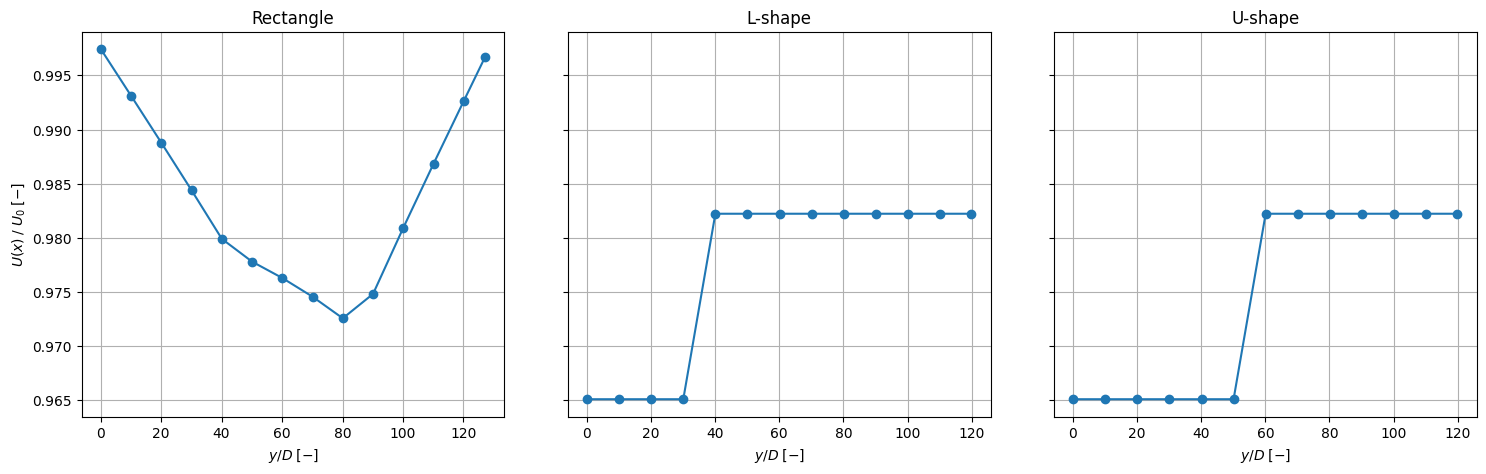

In [31]:
# Create subplots: 1 row, 3 columns, sharing the y-axis
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=False, sharey=True)
fig.subplots_adjust(wspace=0.15)  # Increase the space between plots

# Data and titles
velocity_profiles = [final_velocity_profile1, final_velocity_profile2, final_velocity_profile3]
titles = ["Rectangle", "L-shape", "U-shape"]

# Plot each velocity profile
for ax, profile, title in zip(axes, velocity_profiles, titles):
    ax.plot(profile[:, 0]/D, profile[:, 1]/10, marker='o')
    ax.set_xlabel(r"$ y/D \; [-] $")
    #ax.set_ylim(0.98, 1.0)  # Set y-limits
    ax.set_title(title)
    ax.grid(True)

# Shared y-axis label
axes[0].set_ylabel(r"$ U(x) \; / \; U_0 \; [-] $")

plt.show()

In [33]:
# final_velocity_profile1 structure

# y, recovery_end_uw, zone1['start_x'], zone1['end_x'], deficit_end_uw, h_1[int(x_2)]
# 0, 1,              2,               3,                4,              5

u_s_3_array = []

N_sec = len(final_velocity_profile1)

for i in range(N_sec):

    print(f"------ Section {i} ------")

    l_rec = RL - final_velocity_profile1[i, 3]

    print(f"l_rec: {l_rec:.0f} m")

    l_f = np.max(points1[:,0]) - np.min(points1[:,0])
    w_f = np.max(points1[:,1]) - np.min(points1[:,1])

    print(f"\nl_f: {l_f:.0f} m")
    print(f"w_f: {w_f:.0f} m")

    u_def = final_velocity_profile1[i, 4]
    u_rec = final_velocity_profile1[i, 1]

    print(f"\nu_def: {u_def:.2f} m/s")
    print(f"u_rec: {u_rec:.2f} m/s")

    h_f = final_velocity_profile1[i, 5]

    print(f"h_f: {h_f:.0f} m")

    u_s_2 = (U_0 - u_def) / U_0
    u_s_3 = (U_0 - u_rec) / U_0
    u_s_3_array.append(u_s_3)

    print(f"u_s_2: {u_s_2:.4f}")
    print(f"u_s_3: {u_s_3:.4f}")

    N_wt = int( (l_f+s_x*D)/(s_x*D) * (w_f+s_y*D-(2*D/2))/(s_y*D) )
    T = 1/2 * C_T * np.pi*(D**2)/4 * U_0**2 * N_wt

    print(f"N_wt: {N_wt:.0f}")
    print(f"T: {T/1e6:.0f} MN")

    w_sec = w_f / N_sec

    print(f"\nN_sec: {N_sec:.0f}")
    print(f"w_sec: {w_sec:.0f} m")

    A = w_sec * h_f
    A_2 = T / (U_0**2 * (1 - u_s_2)*u_s_2) / N_sec
    A2_A = A_2 / A

    print(f"\nA: {A/1e6:.2f} km2")
    print(f"A_2: {A_2/1e6:.2f} km2")
    print(f"A2_A: {A2_A:.2f}")

    A_3 = A_2 * ((1 - u_s_2)*u_s_2) / ((1 - u_s_3)*u_s_3)
    A3_A2 = A_3 / A_2

    print(f"A_3: {A_3/1e6:.2f} km2")
    print(f"A3_A2: {A3_A2:.2f}")

    ar = w_sec / h_f

    print(f"ar: {ar:.2f}")

    h_f_2 = np.sqrt(A_2 / ar)
    w_f_2 = np.sqrt(A_2 * ar)
    h_f_3 = np.sqrt(A_3 / ar)
    w_f_3 = np.sqrt(A_3 * ar)

    print(f"\nh_f_2: {h_f_2:.0f} m")
    print(f"w_f_2: {w_f_2:.0f} m")
    print(f"h_f_3: {h_f_3:.0f} m")
    print(f"w_f_3: {w_f_3:.0f} m")

    kx_h = (h_f_3 - h_f_2) / 2 / l_rec
    kx_w = (w_f_3 - w_f_2) / 2 / l_rec

    print(f"\nkx_h: {kx_h:.4f} m/m")
    print(f"kx_w: {kx_w:.4f} m/m")

    k_h = int( kx_h * l_rec )
    k_w = int( kx_w * l_rec )

    print(f"k_h: {k_h:.0f} m")
    print(f"k_w: {k_w:.0f} m\n")


------ Section 0 ------
l_rec: 18478 m

l_f: 12728 m
w_f: 12728 m

u_def: 9.96 m/s
u_rec: 9.97 m/s
h_f: 105 m
u_s_2: 0.0043
u_s_3: 0.0026
N_wt: 187
T: 59 MN

N_sec: 14
w_sec: 909 m

A: 0.10 km2
A_2: 9.90 km2
A2_A: 103.98
A_3: 16.26 km2
A3_A2: 1.64
ar: 8.68

h_f_2: 1068 m
w_f_2: 9270 m
h_f_3: 1369 m
w_f_3: 11881 m

kx_h: 0.0081 m/m
kx_w: 0.0706 m/m
k_h: 150 m
k_w: 1305 m

------ Section 1 ------
l_rec: 17478 m

l_f: 12728 m
w_f: 12728 m

u_def: 8.91 m/s
u_rec: 9.93 m/s
h_f: 429 m
u_s_2: 0.1090
u_s_3: 0.0069
N_wt: 187
T: 59 MN

N_sec: 14
w_sec: 909 m

A: 0.39 km2
A_2: 0.43 km2
A2_A: 1.11
A_3: 6.13 km2
A3_A2: 14.18
ar: 2.12

h_f_2: 451 m
w_f_2: 957 m
h_f_3: 1700 m
w_f_3: 3604 m

kx_h: 0.0357 m/m
kx_w: 0.0757 m/m
k_h: 624 m
k_w: 1323 m

------ Section 2 ------
l_rec: 16478 m

l_f: 12728 m
w_f: 12728 m

u_def: 8.65 m/s
u_rec: 9.89 m/s
h_f: 671 m
u_s_2: 0.1346
u_s_3: 0.0112
N_wt: 187
T: 59 MN

N_sec: 14
w_sec: 909 m

A: 0.61 km2
A_2: 0.36 km2
A2_A: 0.59
A_3: 3.78 km2
A3_A2: 10.49
ar: 1.35

h